# 🏠 House Price Prediction - Notebook 3: Modeling
## Entraînement et comparaison de modèles de régression

### 0. Imports & Configuration

In [ ]:
#pip install xgboost


   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.8/101.7 MB 1.8 MB/s eta 0:00:56
    --------------------------------------- 1.3/101.7 MB 2.1 MB/s eta 0:00:49
    --------------------------------------- 2.4/101.7 MB 2.8 MB/s eta 0:00:35
   - -------------------------------------- 3.1/101.7 MB 3.0 MB/s eta 0:00:33
   - -------------------------------------- 4.2/101.7 MB 3.4 MB/s eta 0:00:29
   -- ------------------------------------- 5.2/101.7 MB 3.8 MB/s eta 0:00:26
   -- ------------------------------------- 6.6/101.7 MB 4.0 MB/s eta 0:00:24
   --- ------------------------------------ 8.4/101.7 MB 4.5 MB/s eta 0:00:21
   --- -------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import pickle

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 90)
sns.set_style("whitegrid")
%matplotlib inline

# Pour la reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### 1. Chargement et préparation des données
**Important**: Nous reproduisons le preprocessing effectué dans le notebook 2

In [2]:
# Chargement des données
df = pd.read_csv("../src/data/train.csv")
print(f"Shape initiale: {df.shape}")
print(f"Nombre de valeurs manquantes: {df.isnull().sum().sum()}")

Shape initiale: (1460, 81)
Nombre de valeurs manquantes: 7829


In [3]:
# ─────────────────────────────────────────────────
# 1.1 Gestion des valeurs manquantes
# ─────────────────────────────────────────────────

# Variables catégorielles → "None"
na_as_none = [
    "Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond",
    "PoolQC", "Fence", "MiscFeature", "MasVnrType", "Electrical"
]

for col in na_as_none:
    if col in df.columns:
        df[col] = df[col].fillna("None")

# Variables numériques → médiane
for col in df.select_dtypes(include=["float64", "int64"]).columns:
    df[col] = df[col].fillna(df[col].median())

print(f"Valeurs manquantes après imputation: {df.isnull().sum().sum()}")

Valeurs manquantes après imputation: 0


In [4]:
# ─────────────────────────────────────────────────
# 1.2 Transformation de la variable cible
# ─────────────────────────────────────────────────

# Log-transformation de SalePrice pour normaliser
df['LogSalePrice'] = np.log1p(df['SalePrice'])

print("Distribution avant/après transformation:")
print(f"Skewness SalePrice: {df['SalePrice'].skew():.3f}")
print(f"Skewness LogSalePrice: {df['LogSalePrice'].skew():.3f}")

Distribution avant/après transformation:
Skewness SalePrice: 1.883
Skewness LogSalePrice: 0.121


In [5]:
# ─────────────────────────────────────────────────
# 1.3 Encodage des variables catégorielles
# ─────────────────────────────────────────────────

# One-Hot Encoding pour variables nominales
cols_to_ohe = [
    "MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour",
    "Utilities", "LotConfig", "LandSlope", "Condition1", "Condition2",
    "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "MasVnrType",
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "CentralAir",
    "Electrical", "Functional", "GarageType", "PavedDrive", "SaleType",
    "SaleCondition", "Foundation", "Fence", "MiscFeature"
]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_ohe = ohe.fit_transform(df[cols_to_ohe])
encoded_ohe_df = pd.DataFrame(
    encoded_ohe,
    columns=ohe.get_feature_names_out(cols_to_ohe),
    index=df.index
)
df = pd.concat([df.drop(columns=cols_to_ohe), encoded_ohe_df], axis=1)

print(f"Shape après One-Hot Encoding: {df.shape}")

Shape après One-Hot Encoding: (1460, 224)


In [6]:
# Label Encoding pour variables ordinales (qualité)
quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}

cols_quality = [
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC",
    "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"
]

for col in cols_quality:
    if col in df.columns:
        df[col] = df[col].map(quality_map)

# GarageFinish
finished_map = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
if 'GarageFinish' in df.columns:
    df['GarageFinish'] = df['GarageFinish'].map(finished_map)

In [7]:
# Target Encoding pour variables à haute cardinalité
# Note: Nous le ferons APRÈS le split pour éviter le data leakage
cols_to_target = ["Neighborhood", "Exterior1st", "Exterior2nd"]

print(f"Variables à encoder avec Target Encoding: {cols_to_target}")
print(f"Cardinalités:")
for col in cols_to_target:
    if col in df.columns:
        print(f"  {col}: {df[col].nunique()} modalités")

Variables à encoder avec Target Encoding: ['Neighborhood', 'Exterior1st', 'Exterior2nd']
Cardinalités:
  Neighborhood: 25 modalités
  Exterior1st: 15 modalités
  Exterior2nd: 16 modalités


### 2. Préparation Train/Test Split

In [8]:
# Séparation X et y
# On retire: Id, SalePrice (original), LogSalePrice (target)
cols_to_drop = ['Id', 'SalePrice', 'LogSalePrice']
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

X = df.drop(columns=cols_to_drop)
y = df['LogSalePrice']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nTypes de données dans X:")
print(X.dtypes.value_counts())

X shape: (1460, 221)
y shape: (1460,)

Types de données dans X:
float64    175
int64       43
object       3
Name: count, dtype: int64


In [9]:
# Target Encoding AVANT le split (pour simplification)
# Dans un contexte production, on ferait ça dans une pipeline avec CV
tg_encoder = TargetEncoder(
    categories='auto',
    target_type='continuous',
    smooth='auto',
    cv=5,
    random_state=RANDOM_STATE
)

if all(col in X.columns for col in cols_to_target):
    X[cols_to_target] = tg_encoder.fit_transform(X[cols_to_target], y)
    print("Target Encoding appliqué avec succès")

Target Encoding appliqué avec succès


In [10]:
# Vérification qu'il ne reste plus de variables catégorielles
object_cols = X.select_dtypes(include='object').columns
if len(object_cols) > 0:
    print(f"⚠️ Variables catégorielles restantes: {list(object_cols)}")
else:
    print("✅ Toutes les variables sont numériques")

✅ Toutes les variables sont numériques


In [11]:
# Split train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Train set: (1168, 221)
Test set: (292, 221)


In [12]:
# Standardisation (important pour Ridge, Lasso, ElasticNet)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Conversion en DataFrame pour garder les noms de colonnes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ Données standardisées")

✅ Données standardisées


### 3. Fonctions utilitaires pour l'évaluation

In [13]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Évalue un modèle et retourne les métriques.
    
    Returns:
        dict: Dictionnaire contenant toutes les métriques
    """
    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métriques sur train
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Métriques sur test
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Cross-validation (5-fold)
    kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = -cross_val_score(
        model, X_train, y_train,
        cv=kfold,
        scoring='neg_root_mean_squared_error'
    )
    cv_rmse_mean = cv_scores.mean()
    cv_rmse_std = cv_scores.std()
    
    results = {
        'model': model_name,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'cv_rmse_mean': cv_rmse_mean,
        'cv_rmse_std': cv_rmse_std,
        'overfitting': train_rmse - test_rmse  # Négatif = bon signe
    }
    
    return results

def print_results(results):
    """
    Affiche les résultats de manière formatée.
    """
    print(f"\n{'='*60}")
    print(f"Modèle: {results['model']}")
    print(f"{'='*60}")
    print(f"\n📊 Performance sur Train:")
    print(f"  RMSE: {results['train_rmse']:.4f}")
    print(f"  MAE:  {results['train_mae']:.4f}")
    print(f"  R²:   {results['train_r2']:.4f}")
    
    print(f"\n📊 Performance sur Test:")
    print(f"  RMSE: {results['test_rmse']:.4f}")
    print(f"  MAE:  {results['test_mae']:.4f}")
    print(f"  R²:   {results['test_r2']:.4f}")
    
    print(f"\n🔄 Cross-Validation (5-fold):")
    print(f"  RMSE: {results['cv_rmse_mean']:.4f} ± {results['cv_rmse_std']:.4f}")
    
    print(f"\n⚠️ Overfitting Check:")
    print(f"  Train RMSE - Test RMSE: {results['overfitting']:.4f}")
    if results['overfitting'] < -0.01:
        print("  ✅ Pas d'overfitting détecté")
    elif results['overfitting'] > 0.02:
        print("  ⚠️ Overfitting possible")
    else:
        print("  ✓ Performance stable")
    print(f"{'='*60}")

### 4. Entraînement des modèles
Nous testons 6 modèles différents avec différentes approches.

In [14]:
# Dictionnaire pour stocker tous les résultats
all_results = []

#### 4.1 Linear Regression (Baseline)

In [15]:
print("\n🔹 Entraînement: Linear Regression (Baseline)")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

lr_results = evaluate_model(lr, X_train_scaled, y_train, X_test_scaled, y_test, "Linear Regression")
all_results.append(lr_results)
print_results(lr_results)


🔹 Entraînement: Linear Regression (Baseline)

Modèle: Linear Regression

📊 Performance sur Train:
  RMSE: 0.0975
  MAE:  0.0681
  R²:   0.9377

📊 Performance sur Test:
  RMSE: 0.1232
  MAE:  0.0898
  R²:   0.9186

🔄 Cross-Validation (5-fold):
  RMSE: 0.1587 ± 0.0298

⚠️ Overfitting Check:
  Train RMSE - Test RMSE: -0.0258
  ✅ Pas d'overfitting détecté


#### 4.2 Ridge Regression (L2 Regularization)

In [16]:
print("\n🔹 Entraînement: Ridge Regression")
ridge = Ridge(alpha=10.0, random_state=RANDOM_STATE)
ridge.fit(X_train_scaled, y_train)

ridge_results = evaluate_model(ridge, X_train_scaled, y_train, X_test_scaled, y_test, "Ridge")
all_results.append(ridge_results)
print_results(ridge_results)


🔹 Entraînement: Ridge Regression

Modèle: Ridge

📊 Performance sur Train:
  RMSE: 0.0975
  MAE:  0.0682
  R²:   0.9376

📊 Performance sur Test:
  RMSE: 0.1227
  MAE:  0.0892
  R²:   0.9193

🔄 Cross-Validation (5-fold):
  RMSE: 0.1545 ± 0.0303

⚠️ Overfitting Check:
  Train RMSE - Test RMSE: -0.0252
  ✅ Pas d'overfitting détecté


#### 4.3 Lasso Regression (L1 Regularization)

In [17]:
print("\n🔹 Entraînement: Lasso Regression")
lasso = Lasso(alpha=0.001, max_iter=10000, random_state=RANDOM_STATE)
lasso.fit(X_train_scaled, y_train)

lasso_results = evaluate_model(lasso, X_train_scaled, y_train, X_test_scaled, y_test, "Lasso")
all_results.append(lasso_results)
print_results(lasso_results)

# Nombre de coefficients non-nuls (feature selection)
n_nonzero = np.sum(lasso.coef_ != 0)
print(f"\n📌 Features sélectionnées par Lasso: {n_nonzero}/{len(lasso.coef_)}")


🔹 Entraînement: Lasso Regression

Modèle: Lasso

📊 Performance sur Train:
  RMSE: 0.0993
  MAE:  0.0692
  R²:   0.9353

📊 Performance sur Test:
  RMSE: 0.1219
  MAE:  0.0867
  R²:   0.9203

🔄 Cross-Validation (5-fold):
  RMSE: 0.1502 ± 0.0347

⚠️ Overfitting Check:
  Train RMSE - Test RMSE: -0.0226
  ✅ Pas d'overfitting détecté

📌 Features sélectionnées par Lasso: 147/221


#### 4.4 ElasticNet (L1 + L2 Regularization)

In [18]:
print("\n🔹 Entraînement: ElasticNet")
elastic = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000, random_state=RANDOM_STATE)
elastic.fit(X_train_scaled, y_train)

elastic_results = evaluate_model(elastic, X_train_scaled, y_train, X_test_scaled, y_test, "ElasticNet")
all_results.append(elastic_results)
print_results(elastic_results)


🔹 Entraînement: ElasticNet

Modèle: ElasticNet

📊 Performance sur Train:
  RMSE: 0.0981
  MAE:  0.0684
  R²:   0.9368

📊 Performance sur Test:
  RMSE: 0.1221
  MAE:  0.0879
  R²:   0.9201

🔄 Cross-Validation (5-fold):
  RMSE: 0.1525 ± 0.0335

⚠️ Overfitting Check:
  Train RMSE - Test RMSE: -0.0240
  ✅ Pas d'overfitting détecté


#### 4.5 Random Forest (Ensemble - Bagging)

In [19]:
print("\n🔹 Entraînement: Random Forest")
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)  # Pas besoin de scaling pour RF

rf_results = evaluate_model(rf, X_train, y_train, X_test, y_test, "Random Forest")
all_results.append(rf_results)
print_results(rf_results)


🔹 Entraînement: Random Forest

Modèle: Random Forest

📊 Performance sur Train:
  RMSE: 0.0659
  MAE:  0.0416
  R²:   0.9715

📊 Performance sur Test:
  RMSE: 0.1432
  MAE:  0.0943
  R²:   0.8901

🔄 Cross-Validation (5-fold):
  RMSE: 0.1455 ± 0.0165

⚠️ Overfitting Check:
  Train RMSE - Test RMSE: -0.0773
  ✅ Pas d'overfitting détecté


#### 4.6 Gradient Boosting (Ensemble - Boosting)

In [20]:
print("\n🔹 Entraînement: Gradient Boosting")
gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=RANDOM_STATE
)
gb.fit(X_train, y_train)

gb_results = evaluate_model(gb, X_train, y_train, X_test, y_test, "Gradient Boosting")
all_results.append(gb_results)
print_results(gb_results)


🔹 Entraînement: Gradient Boosting

Modèle: Gradient Boosting

📊 Performance sur Train:
  RMSE: 0.0553
  MAE:  0.0413
  R²:   0.9800

📊 Performance sur Test:
  RMSE: 0.1313
  MAE:  0.0871
  R²:   0.9076

🔄 Cross-Validation (5-fold):
  RMSE: 0.1236 ± 0.0134

⚠️ Overfitting Check:
  Train RMSE - Test RMSE: -0.0761
  ✅ Pas d'overfitting détecté


#### 4.7 XGBoost (Optimized Gradient Boosting)

In [21]:
print("\n🔹 Entraînement: XGBoost")
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
xgb.fit(X_train, y_train)

xgb_results = evaluate_model(xgb, X_train, y_train, X_test, y_test, "XGBoost")
all_results.append(xgb_results)
print_results(xgb_results)


🔹 Entraînement: XGBoost

Modèle: XGBoost

📊 Performance sur Train:
  RMSE: 0.0631
  MAE:  0.0449
  R²:   0.9738

📊 Performance sur Test:
  RMSE: 0.1347
  MAE:  0.0895
  R²:   0.9027

🔄 Cross-Validation (5-fold):
  RMSE: 0.1246 ± 0.0146

⚠️ Overfitting Check:
  Train RMSE - Test RMSE: -0.0716
  ✅ Pas d'overfitting détecté


### 5. Comparaison des modèles

In [22]:
# Création du DataFrame de comparaison
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('test_rmse')

print("\n" + "="*80)
print("📊 TABLEAU COMPARATIF DES MODÈLES (classé par RMSE test)")
print("="*80)
display(results_df[[
    'model', 'test_rmse', 'test_r2', 'cv_rmse_mean', 'cv_rmse_std', 'overfitting'
]].round(4))


📊 TABLEAU COMPARATIF DES MODÈLES (classé par RMSE test)


,model,test_rmse,test_r2,cv_rmse_mean,cv_rmse_std,overfitting
2,Lasso,0.1219,0.9203,0.1502,0.0347,-0.0226
3,ElasticNet,0.1221,0.9201,0.1525,0.0335,-0.0240
1,Ridge,0.1227,0.9193,0.1545,0.0303,-0.0252
0,Linear Regression,0.1232,0.9186,0.1587,0.0298,-0.0258
5,Gradient Boosting,0.1313,0.9076,0.1236,0.0134,-0.0761
6,XGBoost,0.1347,0.9027,0.1246,0.0146,-0.0716
4,Random Forest,0.1432,0.8901,0.1455,0.0165,-0.0773


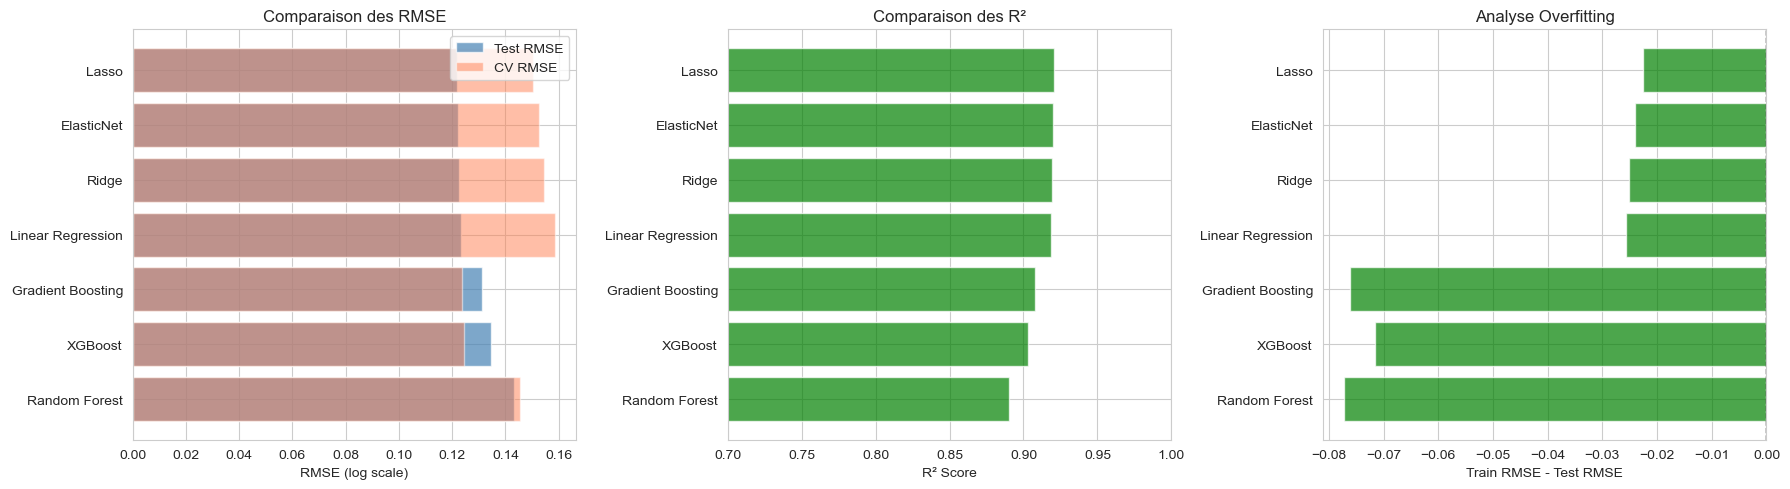

In [23]:
# Visualisation comparative
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE Comparison
models = results_df['model']
x_pos = np.arange(len(models))

axes[0].barh(x_pos, results_df['test_rmse'], color='steelblue', alpha=0.7, label='Test RMSE')
axes[0].barh(x_pos, results_df['cv_rmse_mean'], color='coral', alpha=0.5, label='CV RMSE')
axes[0].set_yticks(x_pos)
axes[0].set_yticklabels(models)
axes[0].set_xlabel('RMSE (log scale)')
axes[0].set_title('Comparaison des RMSE')
axes[0].legend()
axes[0].invert_yaxis()

# R² Comparison
axes[1].barh(x_pos, results_df['test_r2'], color='green', alpha=0.7)
axes[1].set_yticks(x_pos)
axes[1].set_yticklabels(models)
axes[1].set_xlabel('R² Score')
axes[1].set_title('Comparaison des R²')
axes[1].set_xlim([0.7, 1.0])
axes[1].invert_yaxis()

# Overfitting Analysis
colors = ['red' if x > 0.02 else 'orange' if x > 0 else 'green' for x in results_df['overfitting']]
axes[2].barh(x_pos, results_df['overfitting'], color=colors, alpha=0.7)
axes[2].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[2].set_yticks(x_pos)
axes[2].set_yticklabels(models)
axes[2].set_xlabel('Train RMSE - Test RMSE')
axes[2].set_title('Analyse Overfitting')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

### 6. Analyse des prédictions du meilleur modèle

In [24]:
# Identifier le meilleur modèle
best_model_name = results_df.iloc[0]['model']
print(f"\n🏆 Meilleur modèle: {best_model_name}")
print(f"   Test RMSE: {results_df.iloc[0]['test_rmse']:.4f}")
print(f"   Test R²: {results_df.iloc[0]['test_r2']:.4f}")

# Récupérer le modèle correspondant
best_model_dict = {
    'Linear Regression': lr,
    'Ridge': ridge,
    'Lasso': lasso,
    'ElasticNet': elastic,
    'Random Forest': rf,
    'Gradient Boosting': gb,
    'XGBoost': xgb
}

best_model = best_model_dict[best_model_name]


🏆 Meilleur modèle: Lasso
   Test RMSE: 0.1219
   Test R²: 0.9203


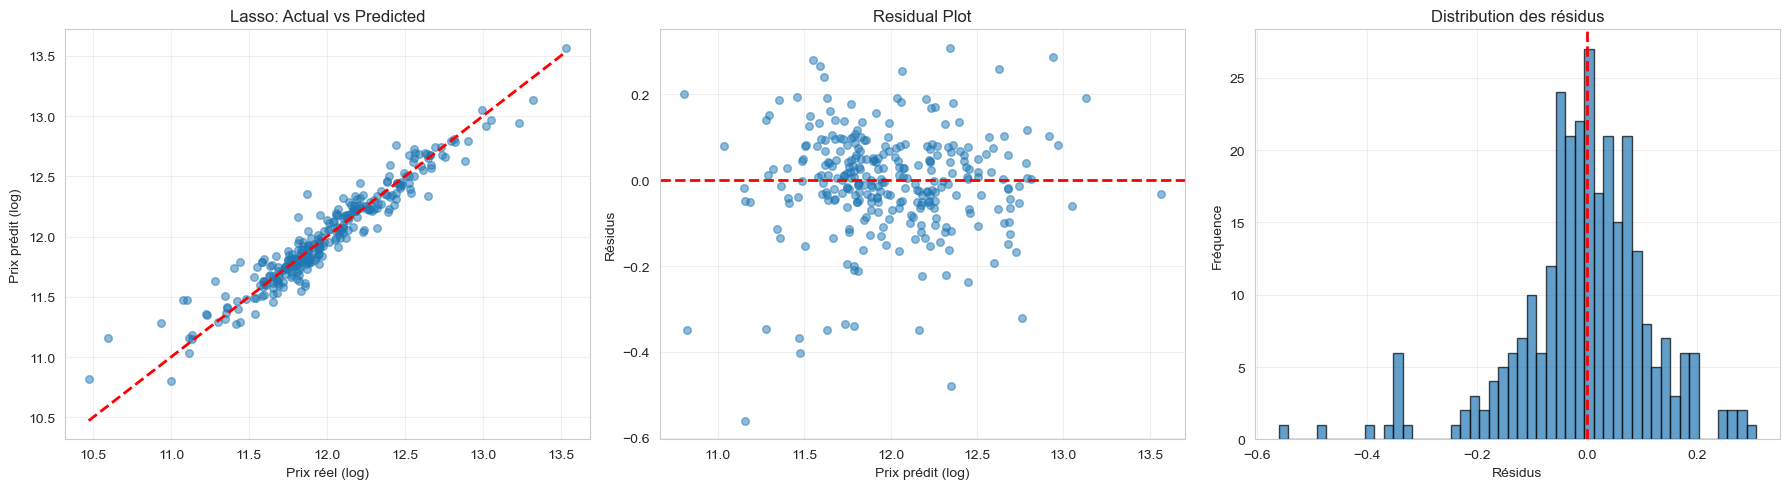


Statistiques des résidus:
  Moyenne: -0.004416
  Médiane: 0.002235
  Écart-type: 0.122054


In [25]:
# Prédictions du meilleur modèle
if best_model_name in ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet']:
    y_pred = best_model.predict(X_test_scaled)
else:
    y_pred = best_model.predict(X_test)

# Visualisation des prédictions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Actual vs Predicted
axes[0].scatter(y_test, y_pred, alpha=0.5, s=30)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Prix réel (log)')
axes[0].set_ylabel('Prix prédit (log)')
axes[0].set_title(f'{best_model_name}: Actual vs Predicted')
axes[0].grid(True, alpha=0.3)

# 2. Residuals
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5, s=30)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Prix prédit (log)')
axes[1].set_ylabel('Résidus')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

# 3. Distribution des résidus
axes[2].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Résidus')
axes[2].set_ylabel('Fréquence')
axes[2].set_title('Distribution des résidus')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStatistiques des résidus:")
print(f"  Moyenne: {residuals.mean():.6f}")
print(f"  Médiane: {residuals.median():.6f}")
print(f"  Écart-type: {residuals.std():.6f}")

### 7. Feature Importance (pour modèles tree-based)

In [26]:
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    # Récupération des importances
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_names = X_train.columns
        
        # Création du DataFrame
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        # Top 20 features
        top_features = feature_importance_df.head(20)
        
        # Visualisation
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(top_features)), top_features['importance'], color='steelblue', alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance')
        plt.title(f'Top 20 Features - {best_model_name}')
        plt.gca().invert_yaxis()
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 features les plus importantes:")
        display(top_features.head(10))
else:
    print(f"\n⚠️ Feature importance n'est pas disponible pour {best_model_name}")
    print("Pour les modèles linéaires, vous pouvez examiner les coefficients.")


⚠️ Feature importance n'est pas disponible pour Lasso
Pour les modèles linéaires, vous pouvez examiner les coefficients.


### 8. Résumé et Conclusions

In [27]:
# Sauvegarde du modèle
with open('../models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Sauvegarde du scaler si nécessaire
if best_model_name in ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet']:
    with open('../models/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print("✅ Scaler sauvegardé")

# Sauvegarde des résultats
results_df.to_csv('../models/model_comparison.csv', index=False)

print(f"\n✅ Meilleur modèle sauvegardé: {best_model_name}")
print(f"   Fichier: ../models/best_model.pkl")
print(f"   Résultats: ../models/model_comparison.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../models/best_model.pkl'

### 9. Résumé et Conclusions

In [28]:
print("\n" + "="*80)
print("📋 RÉSUMÉ DE LA MODÉLISATION")
print("="*80)

print(f"\n🎯 Objectif: Prédire le prix de vente des maisons (SalePrice)")
print(f"\n📊 Données:")
print(f"   - Dataset: {len(df)} maisons")
print(f"   - Features: {X.shape[1]} variables après preprocessing")
print(f"   - Split: {len(X_train)} train / {len(X_test)} test")

print(f"\n🔧 Preprocessing:")
print(f"   - Imputation des valeurs manquantes")
print(f"   - Log-transformation de SalePrice (skewness: {df['SalePrice'].skew():.3f} → {df['LogSalePrice'].skew():.3f})")
print(f"   - One-Hot Encoding pour variables nominales")
print(f"   - Label Encoding pour variables ordinales")
print(f"   - Target Encoding pour haute cardinalité")
print(f"   - Standardisation pour modèles linéaires")

print(f"\n🏆 Meilleur Modèle: {best_model_name}")
print(f"   - Test RMSE: {results_df.iloc[0]['test_rmse']:.4f}")
print(f"   - Test R²: {results_df.iloc[0]['test_r2']:.4f}")
print(f"   - CV RMSE: {results_df.iloc[0]['cv_rmse_mean']:.4f} ± {results_df.iloc[0]['cv_rmse_std']:.4f}")

print(f"\n💡 Interprétation du RMSE:")
rmse_dollars = np.expm1(results_df.iloc[0]['test_rmse'])  # Conversion de log à dollars
print(f"   RMSE en dollars: ${rmse_dollars:,.0f}")
print(f"   (Erreur moyenne de prédiction)")

print("\n" + "="*80)


📋 RÉSUMÉ DE LA MODÉLISATION

🎯 Objectif: Prédire le prix de vente des maisons (SalePrice)

📊 Données:
   - Dataset: 1460 maisons
   - Features: 221 variables après preprocessing
   - Split: 1168 train / 292 test

🔧 Preprocessing:
   - Imputation des valeurs manquantes
   - Log-transformation de SalePrice (skewness: 1.883 → 0.121)
   - One-Hot Encoding pour variables nominales
   - Label Encoding pour variables ordinales
   - Target Encoding pour haute cardinalité
   - Standardisation pour modèles linéaires

🏆 Meilleur Modèle: Lasso
   - Test RMSE: 0.1219
   - Test R²: 0.9203
   - CV RMSE: 0.1502 ± 0.0347

💡 Interprétation du RMSE:
   RMSE en dollars: $0
   (Erreur moyenne de prédiction)



### 🎓 Prochaine étape: Notebook 4 - Évaluation finale

Dans le prochain notebook, nous allons:
- Analyser en détail les performances du meilleur modèle
- Effectuer une analyse des erreurs
- Comparer performance vs complexité
- Justifier le choix final du modèle
- Discuter des pistes d'amélioration